<h1>Preparação dos dados e geração do modelo</h1>

Fonte: https://opendatasus.saude.gov.br/dataset/bd-srag-2020

In [4]:
# bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *

import re

import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# utils

def get_iso_from(date):
    return re.sub(r'(\d+)/(\d+)/(\d+)', r"\3-\2-\1", date)

Consideraremos apenas pessoas que precisaram de UTI. Calculamos o número de dias que a pessoa ficou na UTI. Nosso objetivo é prever quanto tempo uma pessoa necessita de uma UTI.

A próxima célula gera o conjunto de dados <i>data_V1.csv</i>

Se necessário, mude o nome do arquivo na linha 2 da próxima célula.

In [ ]:
# carregando dados
df = pd.read_csv("INFLUD-07-07-2020.csv", encoding ='latin1', sep=";", low_memory=False)

# Filtro (apenas internados)
df = df[df["HOSPITAL"]==1] # 356349 rows

# filtrar por data de saída da UTI não nula
df = df[df["DT_SAIDUTI"].notnull()]

# filtrar por data de entrada da UTI não nula
df = df[df["DT_ENTUTI"].notnull()]

# formatar data de entrada
df["DT_ENTUTI"] = df["DT_ENTUTI"].map(get_iso_from)

# formatar dta de saída
df["DT_SAIDUTI"] = df["DT_SAIDUTI"].map(get_iso_from)

# transformar para datetime object
df["DT_SAIDUTI"] = pd.to_datetime(df["DT_SAIDUTI"], infer_datetime_format=True)
df["DT_ENTUTI"] = pd.to_datetime(df["DT_ENTUTI"], infer_datetime_format=True)

# criar nova coluna de dias na UTI
# essa coluna será o objetivo
df["DAYS_ON_UTI"] = df["DT_SAIDUTI"] - df["DT_ENTUTI"]
df["DAYS_ON_UTI"] = df["DAYS_ON_UTI"].map(lambda date: date.days)

# remover colunas "HOSPITAL", "DT_ENTUTI", "DT_SAIDUTI", "UTI"
df.drop(["HOSPITAL", "DT_ENTUTI", "DT_SAIDUTI", "UTI"], axis=1, inplace=True)

# salvar 
df.to_csv("data_V1.csv", index=None, encoding="utf-8")

<h4>Se já tiver gerado data_V1.csv começar aqui!!!</h4> 

A seguir excluiremos algumas colunas por terem mais de 90% dos dados perdidos.

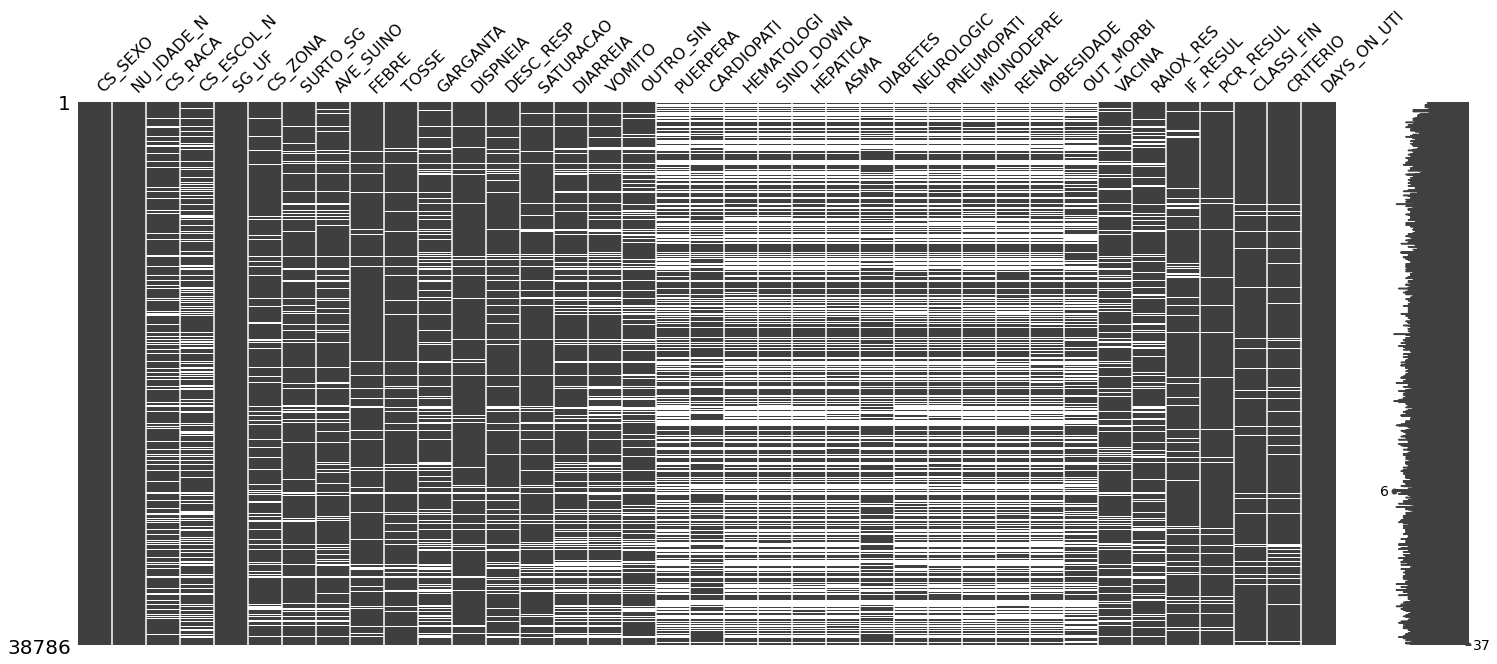

In [5]:
# carregando dados
df = pd.read_csv("data_V1.csv", low_memory=False)

x = [col for col in df.columns if "PAIS" in col][0]
y = [col for col in df.columns if "POS_IF" in col][0]

ignored_features = [
    "SG_UF_NOT", "ID_MUNICIP", "CO_MUN_NOT",                # localização
    "ID_REGIONA", "CO_REGIONA",                             # localização
    "ID_UNIDADE", "CO_UNI_NOT",                             # localização
    "ID_RG_RESI", "CO_RG_RESI", "ID_MN_RESI", "CO_MUN_RES", # localização

    "ID_PAIS", "CO_PAIS",                                   # localização

    "DT_NASC", "TP_IDADE",                                  # redundante (idade)

    "SEM_PRI", "DT_SIN_PRI", "SEM_NOT", "DT_NOTIFIC",       # notificação e primeiros sintomas

    "DT_INTERNA", "SG_UF_INTE", "ID_RG_INTE", "CO_RG_INTE",  # dados da internação
    "ID_MN_INTE", "CO_MU_INTE",                              # dados da internação       

    "HISTO_VGM", "CO_PS_VGM", "LO_PS_VGM",                  # viagem internacional
    "DT_VGM", "DT_RT_VGM",                                  # viagem internacional

    "OBES_IMC",                                            # redundante com IMC
    "OUTRO_DES",                                            # outros sintomas (TEXT, depois)
    "MORB_DESC",                                            # fatores de risco (TEXT, depois)
    "RAIOX_OUT",  
    "COD_IDADE",
    # resultado raio X (TEXT, depois)

    "DT_UT_DOSE",                                           # data última dose vacina gripe
    "MAE_VAC", "DT_VAC_MAE", "M_AMAMENTA",                  # dados da mãe se menor

    "DT_DOSEUNI", "DT_1_DOSE", "DT_2_DOSE",                 # dados de vacina (6 meses a 8 anos)

    "ANTIVIRAL", "TP_ANTIVIR", "DT_ANTIVIR",                # dados de uso de antiviral

    "SUPORT_VEN",                                           # uso ventilador (ver depois)

    "DT_RAIOX", "DT_IF", "TP_FLU_IF", "DT_PCR",               # exames
    "AMOSTRA", "DT_COLETA", "TP_AMOSTRA", "OUT_AMOST",        # exames
    "IF_VSR", "IF_PARA1", "IF_PARA2", "IF_PARA3", "IF_ADENO", # exames

    "IF_OUTRO", "DS_IF_OUT",                                # outros agentes biológicos

    "POS_PCRFLU", "TP_FLU_PCR", "PCR_FLUASU", "FLUASU_OUT", # exames (muitos dados nulos)
    "PCR_FLUBLI", "FLUBLI_OUT", "POS_PCROUT", "PCR_SARS2",  # exames (muitos dados nulos)
    "PCR_VSR", "PCR_PARA1", "PCR_PARA2", "PCR_PARA3",       # exames (muitos dados nulos)
    "PCR_PARA4", "PCR_ADENO", "PCR_METAP", "PCR_BOCA",      # exames (muitos dados nulos)
    "PCR_RINO", "PCR_OUTRO", "DS_PCR_OUT",                  # exames (muitos dados nulos)

    "EVOLUCAO", "DT_EVOLUCA", "DT_ENCERRA",                 # cura, obito (ver depois)

    "DT_DIGITA",                                            # data digitação
    "NOSOCOMIAL",                                           # SG após internação
    "CS_GESTANT",                                           # gestante
    "CS_ETINIA", "POS_IF_FLU", 'POS_IF_OUT'
    'PAIS_VGM', "PAC_COCBO", "PAC_DSCBO", "CLASSI_OUT", "OUT_ANTIV"
]
df = df[[col for col in df.columns if col not in ignored_features + [x, y]] ]
df = df.iloc[:, [i for i in range(len(df.columns)) if i not in [33,37]]]

msno.matrix(df)
plt.show()

<h3>Pré-processamento</h3>

In [4]:
exp_reg101 = setup(
    data = df,
    target = 'DAYS_ON_UTI', 
    categorical_features = [
        "CS_SEXO", "CS_RACA","CS_ESCOL_N",   # pessoal
        "CS_ZONA", "VACINA",    # pessoal
        
        "SURTO_SG",                                        # proveniente de sindrome grave?
        
        "AVE_SUINO", "FEBRE", "TOSSE", "GARGANTA", "CRITERIO",              # sintomas
        "DISPNEIA", "DESC_RESP", "SATURACAO", "DIARREIA", "VOMITO",         # sintomas
        "PUERPERA", "CARDIOPATI", "HEMATOLOGI", "SIND_DOWN", "HEPATICA",    # sintomas
        "ASMA", "DIABETES", "NEUROLOGIC", "PNEUMOPATI", "IMUNODEPRE",       # sintomas
        "RENAL", "OUT_MORBI", "OBESIDADE",                                  # sintomas
        
        "RAIOX_RES", "IF_RESUL",                               # exames
        "PCR_RESUL",                            # exames
        
        "CLASSI_FIN",                                                       # classificação final
        
    ],
    date_features = [
        'NU_IDADE_N', 
    ],
    high_cardinality_features = [
        "SG_UF", 
    ],
    normalize=True,
    normalize_method="robust",
    pca = True,
    pca_components = 0.9,
    session_id=123)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(38786, 37)"
4,Missing Values,True
5,Numeric Features,0
6,Categorical Features,35
7,Ordinal Features,False
8,High Cardinality Features,True
9,High Cardinality Method,frequency


Foram considerados apenas features 
Em features categóricas, a técnica de One Hot Encoding foi aplicada.

<h3>Escolha do modelo</h3>

In [5]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,5.892600,72.150500,8.488300,0.027900,0.981800,1.586400
1,Ridge Regression,5.891200,72.184700,8.490400,0.027400,0.980700,1.583400
2,Least Angle Regression,5.891200,72.184800,8.490400,0.027400,0.980700,1.583400
3,Linear Regression,5.891200,72.184800,8.490400,0.027400,0.980700,1.583400
4,CatBoost Regressor,5.899800,72.415000,8.504200,0.024200,0.981700,1.582900
5,Extreme Gradient Boosting,5.912900,72.448700,8.505700,0.023900,0.984400,1.596000
6,Gradient Boosting Regressor,5.926100,72.634000,8.516700,0.021400,0.985800,1.603200
7,Orthogonal Matching Pursuit,5.933100,72.727900,8.522300,0.020100,0.988900,1.605500
8,TheilSen Regressor,5.844700,72.780300,8.525200,0.019400,0.973700,1.533900
9,Light Gradient Boosting Machine,5.949800,73.422000,8.562500,0.010900,0.986100,1.591700


<h3>Avaliando o modelo escolhido</h3>

In [6]:
svm = create_model('svm', fold=10, round=4)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,5.2083,74.0123,8.6030,-0.0411,0.8939,0.9805
1,5.3066,70.4458,8.3932,-0.0633,0.8990,0.9993
2,5.5988,92.9913,9.6432,-0.0539,0.9091,0.9895
3,5.4914,79.0473,8.8909,-0.0626,0.9071,1.0237
4,5.4833,75.0996,8.6660,-0.0815,0.8988,0.9807
5,5.5538,83.1352,9.1179,-0.0845,0.9022,0.9974
6,5.3861,80.0525,8.9472,-0.0524,0.9039,0.9969
7,5.5534,79.5280,8.9178,-0.0613,0.9064,1.0294
8,5.4334,79.5473,8.9189,-0.0666,0.9119,0.9835
9,5.2575,73.7358,8.5870,-0.0444,0.8898,1.0259


In [10]:
evaluate_model(svm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

A acuráica a seguir é medida no teste:

In [11]:
predict_model(svm);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Support Vector Regressor,5.1956,73.7242,8.5863,-0.0465,0.8837,1.0102


<h3>Finalizando e salvando o modelo</h3>

In [12]:
final_svm = finalize_model(svm)

In [14]:
save_model(final_svm,'svm_model_12072020')

Transformation Pipeline and Model Succesfully Saved


<h3>Testando modelo com dados aleatórios</h3>

In [3]:
d ={
	"CS_SEXO": [
		1
	],
	"NU_IDADE_N": [
		500
	],
	"CS_RACA": [
		2.0
	],
	"CS_ESCOL_N": [
		2.0
	],
	"SG_UF": [
		"RS"
	],
	"CS_ZONA": [
		None
	],
	"SURTO_SG": [
		2.0
	],
	"AVE_SUINO": [
		2.0
	],
	"FEBRE": [
		1.0
	],
	"TOSSE": [
		2.0
	],
	"GARGANTA": [
		2.0
	],
	"DISPNEIA": [
		1.0
	],
	"DESC_RESP": [
		1.0
	],
	"SATURACAO": [
		1.0
	],
	"DIARREIA": [
		2.0
	],
	"VOMITO": [
		2.0
	],
	"OUTRO_SIN": [
		1.0
	],
	"PUERPERA": [
		1.0
	],
	"CARDIOPATI": [
		2.0
	],
	"HEMATOLOGI": [
		2.0
	],
	"SIND_DOWN": [
		2.0
	],
	"HEPATICA": [
		2.0
	],
	"ASMA": [
		2.0
	],
	"DIABETES": [
		2.0
	],
	"NEUROLOGIC": [
		2.0
	],
	"PNEUMOPATI": [
		2.0
	],
	"IMUNODEPRE": [
		2.0
	],
	"RENAL": [
		2.0
	],
	"OBESIDADE": [
		2.0
	],
	"OUT_MORBI": [
		None
	],
	"VACINA": [
		2.0
	],
	"RAIOX_RES": [
		2.0
	],
	"IF_RESUL": [
		9.0
	],
	"PCR_RESUL": [
		2.0
	],
	"CLASSI_FIN": [
		4.0
	],
	"CRITERIO": [
		1.0
	]
}
to_pred_df = pd.DataFrame(d)

new_prediction = predict_model(model, data=to_pred_df)
new_prediction["Label"].values[0]

3.9429